In [ ]:
!head input_plaintext.txt

In [ ]:
!head power_traces.csv

In [ ]:
!pip install cryptography

In [107]:
import csv
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr
import numpy as np
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

In [4]:
traces = []

count = 0
with open('power_traces.csv', 'r') as power_traces:
    trace = csv.reader(power_traces, delimiter=',')
    for line in trace:
        value = [int(x) for x in line]
        traces.append(value)

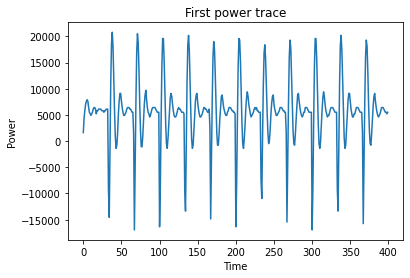

In [5]:
plt.plot(traces[0])

plt.xlabel('Time')
plt.ylabel('Power')
plt.title('First power trace')
# plt.show()
plt.savefig('figure2')

In [6]:
plaintext = []
with open('input_plaintext.txt', 'rb') as plaintext_file:
    for plain in plaintext_file:
        plaintext.append(int(plain, base=16))

In [7]:
ciphertext = []
with open('output_ciphertext.txt', 'rb') as ciphertext_file:
    for cipher in ciphertext_file:
        ciphertext.append(int(cipher, base=16))

In [8]:
hamming_weight = [bin(n).count("1") for n in range(0, 256)]

def get_byte(text, byte_num):
    bit_shift = 120 - (8 * byte_num)
    mask = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF >> bit_shift
    mask = mask & 0xFF
    mask = mask << bit_shift
    return (text & mask) >> bit_shift

In [9]:
x_range = [ *range(0, 400) ]
# x_range = [ 33 ]

t_start = 25
t_end = 35
byte_guess = [ *range(0, 256) ]
byte_range = [ *range(0, 16) ]
byte_num = 0

In [56]:
hw_input = [[[] for k in byte_guess] for b in byte_range]

power_trace = np.transpose(traces)

for i in range(0, len(traces)):
    for byte_num in byte_range:
        # if byte_num != 0:
        #     continue

        # find hamming weight between plaintext and key guess
        pt = get_byte(plaintext[i], byte_num)

        for key_guess in byte_guess:
            hw = hamming_weight[pt ^ key_guess]
            hw_input[byte_num][key_guess].append(hw)


In [11]:
# from pprint import pprint
# t x 10k matrix (transpose of original)
print(len(power_trace), len(power_trace[30])) #,  len(power_trace[30][0])) 

# t x key_guess (256) x 10k matrix
print(len(hw_input), len(hw_input[0]), len(hw_input[0][0]))

400 10000
16 256 10000


In [58]:
coefficients = [[[] for k in byte_guess] for b in byte_range]

for byte_num, hw_trace in enumerate(hw_input):
    # if byte_num != 1:
    #     continue
    for k, hw in enumerate(hw_trace):
        for power in power_trace:
            correlation = pearsonr(hw, power)
            coefficients[byte_num][k].append(correlation[0]) 

print(len(coefficients), len(coefficients[0]), len(coefficients[0][0]))

16 256 400


In [51]:
evolution = [[[] for k in byte_guess] for b in byte_range]

for byte_num, hw_trace in enumerate(hw_input):
    # if byte_num != 0:
    #     continue
    for k, hw in enumerate(hw_trace):
        for e in range(2, 10000):
            correlation = pearsonr(hw[0:e], power_trace[43][0:e])
            evolution[byte_num][k].append(correlation[0]) 

print(len(evolution), len(evolution[0]), len(evolution[0][0]))

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


16 256 9998


In [ ]:
max_correlations = []
for k in range(len(evolution[0])):
    max_correlations.append(evolution[0][k][9997])

zoom_in = [*range(300,5000)]
for k in range(len(evolution[0])):
    plt.plot(zoom_in, evolution[0][k][300:5000])

plt.savefig('figure5')
plt.show()

In [ ]:
for k in byte_guess:
    print(np.argmax(coefficients[0][k]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


36


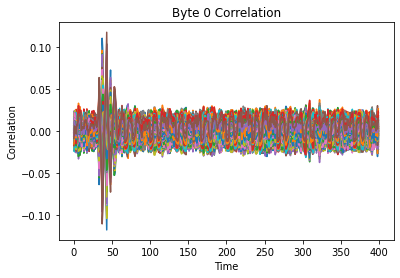

In [36]:
for k in byte_guess:
    # plt.plot(byte_guess, transpose_matrix[k])
    plt.plot(x_range, coefficients[0][k])
    # break

# plt.legend()
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Byte 0 Correlation')
# plt.show()
plt.savefig('figure3')

In [100]:
key = []

possible_keys = [[] for b in byte_range]

for b in byte_range:
    rank_coefficients = {}

    for k in byte_guess:
        max = np.max(coefficients[b][k])
        min = np.min(coefficients[b][k])
        rank_coefficients[k] = max if abs(max) > abs(min) else min 

    best_keys = sorted(rank_coefficients.items(), key=lambda item: item[1], reverse=True)

    # print(best_keys)
    key_1 = best_keys[0][0]
    key_2 = best_keys[1][0]

    for i in range(0, 2):
        possible_keys[b].append(best_keys[i][0])

    # plt.plot(coefficients[byte_focus][key_1])
    # plt.plot(coefficients[byte_focus][key_2])

    # print('best keys: ', key_1, key_2)
    # print(key_1, np.max(coefficients[b][key_1]), np.argmax(coefficients[b][key_1]), np.min(coefficients[b][key_1]), np.argmin(coefficients[b][key_1]))
    # print(key_2, np.max(coefficients[b][key_2]), np.argmax(coefficients[b][key_2]), np.min(coefficients[b][key_2]), np.argmin(coefficients[b][key_2]))

    # val = 0
    # if np.max(coefficients[b][key_1]) > np.max(coefficients[b][key_2]):
    #     val = key_1
    # else: 
    #     val = key_2

    # key.append(val)

# plt.savefig('figure4')
# plt.show()

In [101]:
possible_keys

[[255, 247],
 [254, 246],
 [253, 245],
 [252, 188],
 [251, 187],
 [122, 250],
 [249, 233],
 [7, 184],
 [247, 245],
 [9, 11],
 [245, 229],
 [244, 228],
 [243, 140],
 [77, 13],
 [241, 209],
 [240, 176]]

In [ ]:
generated_keys = []

for c in range(0, 2):
    guess_key = []
    for b in byte_range:
        generated_keys[b].append(possible_keys[b][c])
        break

In [86]:
found_key = key
found_key

[255, 254, 253, 252, 251, 122, 249, 7, 247, 9, 245, 244, 243, 77, 241, 240]

In [103]:
key = [255, 254, 253, 252, 251, 122, 249, 248, 247, 9, 245, 244, 243, 178, 241, 240]

Testing key

In [104]:
guess = bytearray(key)
guess

bytearray(b'\xff\xfe\xfd\xfc\xfbz\xf9\xf8\xf7\t\xf5\xf4\xf3\xb2\xf1\xf0')

In [105]:
cipher = Cipher(algorithms.AES128(bytearray(key)), modes.ECB())
encryptor = cipher.encryptor()
ct = encryptor.update(plaintext[0].to_bytes(16, 'big')) + encryptor.finalize()
# decryptor = cipher.decryptor()
# decryptor.update(ct) + decryptor.finalize()
print(ct)
plaintext[0].to_bytes(16, 'big')

b'\xab\x81\nW\n\x1cz7\xbb\xf8\x92\x82\x9d\xdaC\xfa'


b'\xb9\xd1\xc4\x8e4\x8f\xe7q\xfaFJw\xa1x\xfb\x07'

In [102]:
rand_index = 0

print(hex(plaintext[rand_index]))
print(hex(ciphertext[rand_index]))

246996355882591798086594854227581401863
199345347414874911024061709309167951330
